# Assessing the Extent of a Flood Event using Python: A Change Detection Approach with Landsat Imagery


In [1]:
# Import earth-analytics-python packages and libraries
import seaborn as sns
import os
import folium
from folium import plugins
import pandas as pd
import geopandas as gpd
import numpy as np
from glob import glob
import rasterio as rio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.plot import plotting_extent
from rasterio.mask import mask
import earthpy as et
import earthpy.spatial as es
import clip_data as cl
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from shapely.geometry import mapping
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap, BoundaryNorm
%matplotlib inline
# Set directory
os.environ["PROJ_LIB"] = r"C:\Users\tonif_000\Anaconda3\envs\earth-analytics-python\Library\share"
#os.chdir(os.path.join(et.io.HOME, 'flood_analysis'))

# Set standard plot parameters for uniform plotting
mpl.rcParams['figure.figsize'] = (10, 10)
mpl.rcParams['axes.titlesize'] = 20
plt.rcParams['figure.figsize'] = (10, 10)

# Plot with seaborn
sns.set(font_scale=1.5)
sns.set_style("whitegrid")

## About the 2008 Midwest Floods

During the summer of 2008, areas in the Midwest (United States) experienced major flooding as a result of heavy rainfall and overflowing rivers. The states effected by severe flooding and levee failures included Illinois and Indiana.   

On June 10, 2008 Lawrence County, IL experienced 4 levee failures along the Embarras River (central-western side of county) and the Wabash River (eastern side of county) The Wasbash river flows along the Illinois-Indiana state line. 

On June 11, 2008 Lawrence County was declared a disaster area [5].


## Overview of the Study Area: Lawrence County, Illinois

Zoom in the image to explore the area. Pay close attention to the location of the Embarras River and Wabash River

In [2]:
# Create a map using Stamen Terrain as the basemap
m = folium.Map(location=[38.7158, -87.7763])

# Display map
m

This is a terrain view of the study area

In [3]:
# Create a map using Stamen Terrain as the basemap
m = folium.Map(location=[38.7158, -87.7763],
              tiles = 'Stamen Terrain')

# Display map
m

#### The following is to support the data for flood event background and study area (this data is not used in the analysis).

The Flood event occured on June 10th through the 11th. Notice how much rain the study area already received from May 2008.

In [4]:
# Define path for preciptation data within study area
precip_may_jun_2008_path = "data/precipitation/LAWRENCEVILLE_2_WSW_IL_US _GHCND_USC00114957_precipitation.csv"

# Read the data
precip = pd.read_csv(precip_may_jun_2008_path,
                     parse_dates=['DATE'],
                     index_col=['DATE'])

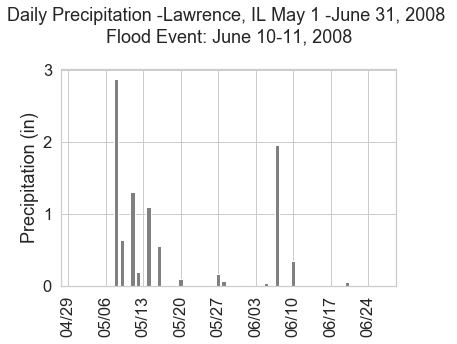

In [5]:
# Plot the precipitation data

# Define the format for date labels on the x axis
myFmt = DateFormatter("%m/%d")

fig, ax = plt.subplots()

ax.bar(precip.index.values, precip['PRCP'].values, color='grey')

# Add lables and title
ax.set(xlabel='', ylabel='Precipitation (in)')
ax.set(title='Daily Precipitation -Lawrence, IL May 1 -June 31, 2008 \n Flood Event: June 10-11, 2008 \n')
# Change orientation of x axis tick marks - easier to read labels
plt.xticks(rotation=90)

ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(myFmt)
plt.show()

## How do you use python to extract the extent of a flood using python? 
Python has many packages available for geospatial analysis. I highly recommend utilizing earthpy published by the EarthLab at the University of Colorado Boulder. This python package is great for people who are interested in manipulating geospatial data in python. You can find more information about the earthpy package. [Click here.](https://github.com/earthlab/earthpy)

The following analysis primarily utilizes pandas, geopandas, rasterio. Check out the the ``earthpy`` documentation to learn more!


## About the data: 

### Landsat 5 Thematic Mapper (TM) Images
Landsat 5 TM has a total of 8 bands and has a spatial resolution of 30 meters. If you would like to learn more about these bands and how they are best used in a study, check out this post from the [U.S. Geological Survey](https://landsat.usgs.gov/what-are-best-spectral-bands-use-my-study). 

It is important to note that my analysis uses Landsat 5 TM bands 2 and 4

Two Landsat 5 TM images used in the flood extent analysis were taken on June 9, 2007 and June 11, 2008. The figure below shows the June 2007 band 5 image on the left where there is no flooding and the June 2008 image shows the flooding a day after the flood waters began to rise. 

The two images that the majority of the land-use is used for agricultural purposes with low to medium density urban areas within Lawrence County, IL. This will become more relevant when I discuss my approach to identify water in the imagery. 

The Landsat 5 TM imagery was obtained from [Earth Explorer](https://earthexplorer.usgs.gov/). 

### Illinois Shapefile
Illinois shape file was used to identify and set the extent of the analysis. It contains information from the 2010 United States Census. This data was obtained from United States Census Bureau| TIGER/Line Shapefiles and can be downloaded [here.](https://www.census.gov/geo/maps-data/data/tiger-line.html)


### Extracting the Flood Event from Landsat 5 TM Imagery. 
#### How did I extract the flood event?  


### Methodology
My analysis presents a method to measure the extent of flooding disasters by using python to derive the Normalized Difference Water Index (NDWI) from Landsat 5 Thematic Mapper imagery and conduct change detection analysis. 

### Flood Extent
The flood extent was extracted from the Normalized Difference Water Index (NDWI) derived from Band 2 and Band 4 Landsat 5 TM imagery. 

Band 2 and Band 4 were used calculate NDWI in order to identify flood water extent. The flood area was then extracted from the classified image in order to identify the extent of flood damage in Lawrence County, IL. 

### Results
Approximately 12.4 % of the total area in Lawrence County received flooding on June 11, 2008.

### Import the data for analysis

#### Data for flood extent analysis

In [6]:
# Country and State Boundaries for the study area
illinois_path = "data/study_area/Illinois/vector/tl_2008_17_tract00/tl_2008_17_tract00.shp"

# Lansat 5 TM Pre and Post Flood
# Grab bands 2 and 4
ndwi_bands_pre_path = glob(
    "data/study_area/Illinois/landsat/pre_flood/LT5022033007160GNC01-2015-11-19/LT5022033007160GNC01/*B[2,4]*.tif")

ndwi_bands_post_path = glob(
    "data/study_area/Illinois/landsat/post_flood/LT50220332008163GNC02/*B[2,4]*.tif")

# Sort the landsat bands
ndwi_bands_pre_path.sort()
ndwi_bands_post_path.sort()

### Identify the Study Area: Lawrence County, IL

#### 1. Set the Extent to the Study Area: Lawrence County, IL

The study area of this analysis will focus on Lawrence County, Illinois. The Lawrence County shapefile was obtained from the original  Illinois shapefile, by  subseting  the geodataframe  data to  Lawrence County


C:\Users\tonif_000\Anaconda3\envs\earth-analytics-python\lib\site-packages\geopandas\io\file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


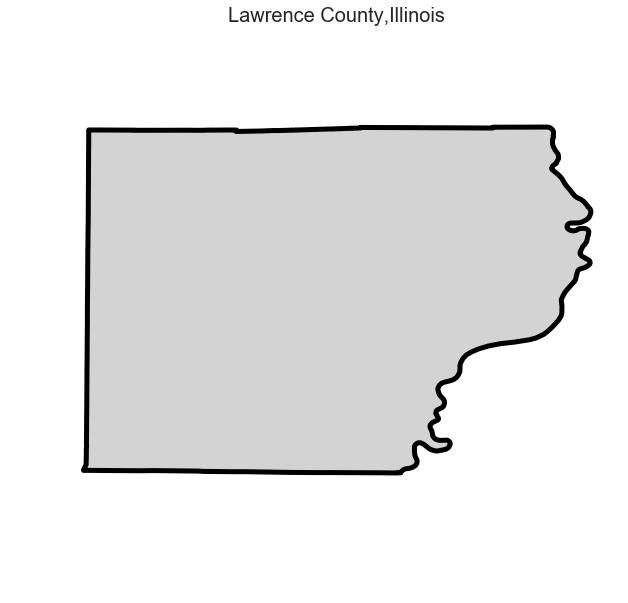

In [7]:
# Read Illinois shapefile
illinois = gpd.read_file(illinois_path)

# Subset the data for Lawrence County
IL_counties = illinois[['COUNTYFP00', 'geometry']]
IL_dissolved = illinois.dissolve(by='COUNTYFP00')
county = IL_dissolved[IL_dissolved.index == '101']

# Export county as shapefile to Lawrence County Folder
county.to_file("data/study_area/lawrence_county_IL/vector/county.shp")

# Plot Lawrence County
fig, ax = plt.subplots(figsize=(10, 10))


county.plot(alpha=1,
            facecolor='lightgrey',
            edgecolor='black',
            linewidth=5,
            zorder=15,
            ax=ax)

ax.set_title('Lawrence County,Illinois', fontsize=20)

ax.set_axis_off()
plt.axis('equal')
plt.show()

In [8]:
# Read the county .shp to crop Landsat 5 TM imagery
county = gpd.read_file("data/study_area/lawrence_county_IL/vector/county.shp")
county

,STATEFP00,TRACTCE00,CTIDFP00,NAME00,NAMELSAD00,MTFCC00,FUNCSTAT00,geometry
0,17,981000,17101981000,9810,Census Tract 9810,G5020,S,"POLYGON ((-87.53516399999999 38.681437, -87.54..."


### Crop Landsat Imagery to Study Area (Lawrence County, IL)

To obtain only the flood extent within Lawrence County, I cropped the Landsat 5 TM imagery to the extent of the county shapefile. Think about this as a way applying a cookie cutter to the Landsat 5 TM imagery. 


#### Pre-Flood

In [9]:
# Open and crop each Landsat 5 TM and to study area (Lawrence County)

# Band 2 - Green Band
with rio.open(ndwi_bands_pre_path[0]) as green_band_pre:
    county_prj = county.to_crs(green_band_pre.crs)
    extent_geojson = mapping(county_prj['geometry'][0])
    green_band_pre_im, green_band_pre_meta = es.crop_image(green_band_pre,
                                                           [extent_geojson])

# Band 4 - Near Infrared Band (NIR)
with rio.open(ndwi_bands_pre_path[1]) as nir_band_pre:
    county_prj = county.to_crs(nir_band_pre.crs)
    extent_geojson = mapping(county_prj['geometry'][0])
    nir_band_pre_im, nir_band_pre_meta = es.crop_image(nir_band_pre,
                                                       [extent_geojson])

(<Figure size 864x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a025d8f470>)

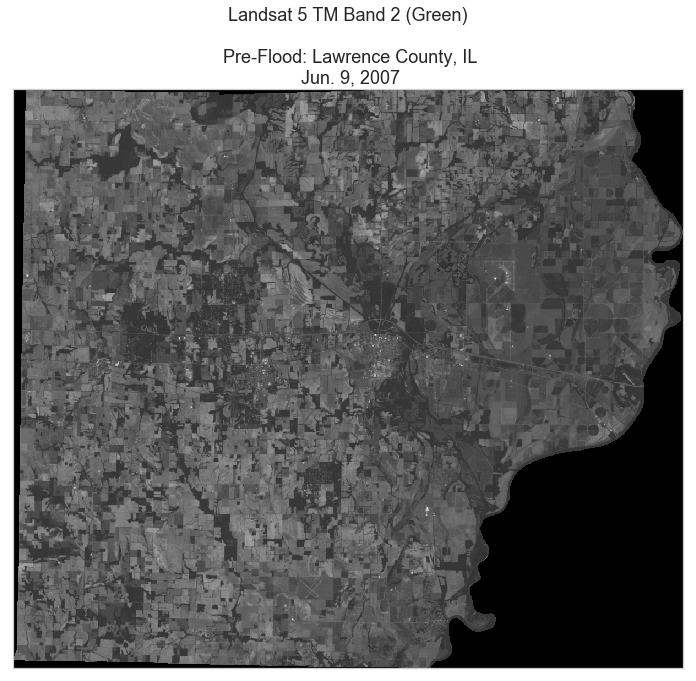

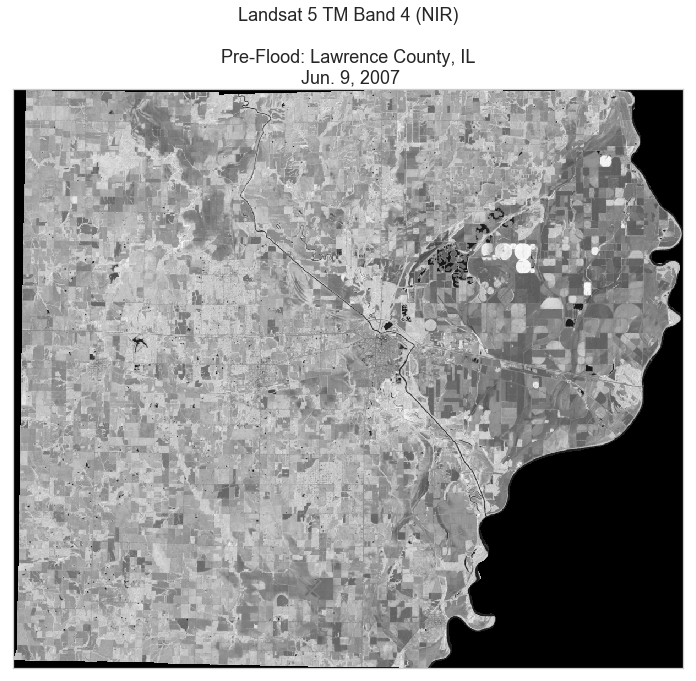

In [10]:
# Plot the cropped Landsat Data
es.plot_bands(green_band_pre_im,
              title="Landsat 5 TM Band 2 (Green)\n\n Pre-Flood: Lawrence County, IL\n Jun. 9, 2007",
              cmap="Greys_r")

es.plot_bands(nir_band_pre_im,
              title="Landsat 5 TM Band 4 (NIR)\n\nPre-Flood: Lawrence County, IL\n Jun. 9, 2007",
              cmap="Greys_r")


The images below are greyscale Landsat 5 TM Band 2 and Band 4 images that were used to calculate the NDWI. These bands are known to do a better job at distinguishing flood water pixels 

#### Post-Flood

In [11]:
# Open and crop bands to study area (Lawrence County)

# Band 2 - Green Band
with rio.open(ndwi_bands_post_path[0]) as green_band_post:
    county_prj = county.to_crs(green_band_post.crs)
    extent_geojson = mapping(county_prj['geometry'][0])
    green_band_post_im, green_band_post_meta = es.crop_image(green_band_post,
                                                             [extent_geojson])

# Band 4 - Near Infrared Band (NIR)
with rio.open(ndwi_bands_post_path[1]) as nir_band_post:
    county_prj = county.to_crs(nir_band_post.crs)
    extent_geojson = mapping(county_prj['geometry'][0])
    nir_band_post_im, nir_band_post_meta = es.crop_image(nir_band_post,
                                                         [extent_geojson])

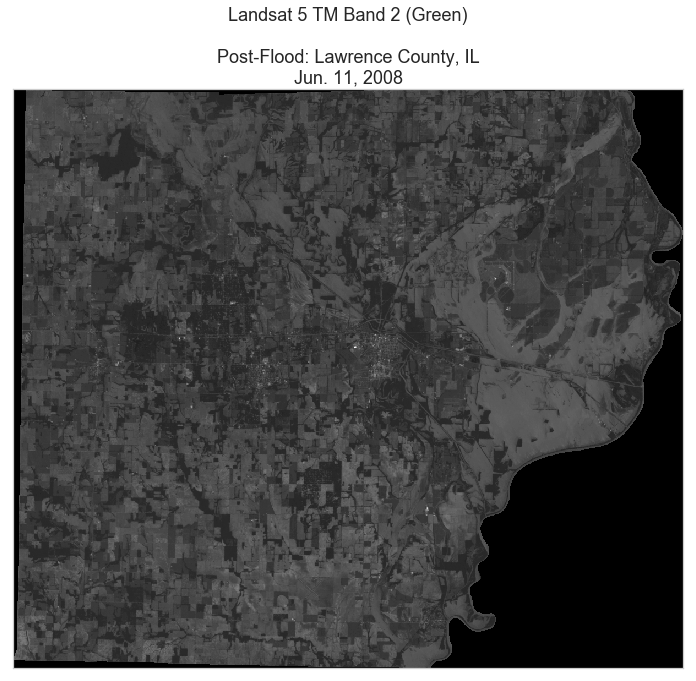

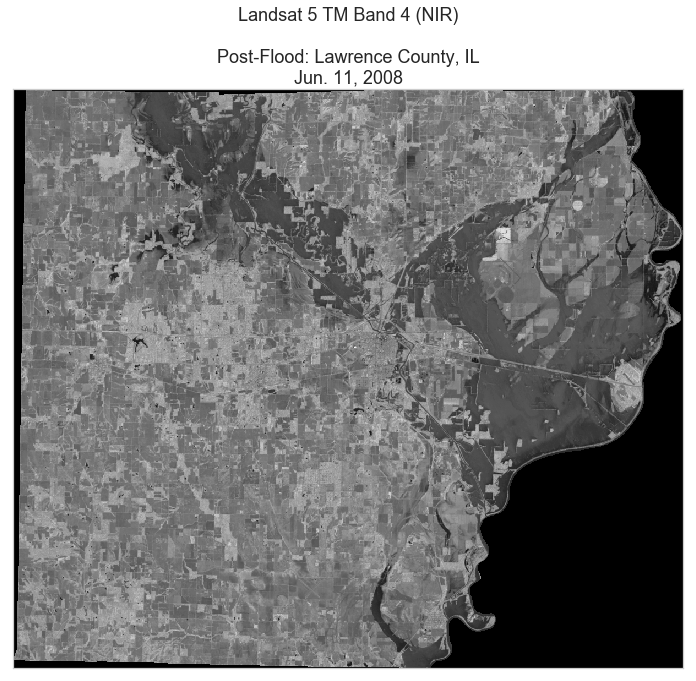

In [12]:
# Plot the cropped Landsat Data
es.plot_bands(green_band_post_im,
              title="Landsat 5 TM Band 2 (Green)\n\n Post-Flood: Lawrence County, IL \n Jun. 11, 2008 ",
              cmap="Greys_r")
# Save the image
plt.savefig('images/green_band_post_im.png')

es.plot_bands(nir_band_post_im,
              title="Landsat 5 TM Band 4 (NIR)\n\n Post-Flood: Lawrence County, IL \n Jun. 11, 2008 ",
              cmap="Greys_r")
# Save the image
plt.savefig('images/nir_band_post_im.png')

The images below are greyscale Landsat 5 TM Band 2 and Band 4 images that were used to calculate the NDWI. These bands are known to do a better job at distinguishing flood water pixels 

## Calculate Normalized Difference Water Index (NDWI) Using Earthpy

#### 2. Normlaized Difference Water Index (NDWI)Analysis - Identify pixels containing  flood water:
The Normalized Difference Water Index (NDWI) was really powerful for this analysis. Notice how water is clearly distinguished in both images as seen in figures below. 

The formula used in this analysis can be found in the resources below [6]

#### Pre-Flood

C:\Users\tonif_000\Anaconda3\envs\earth-analytics-python\lib\site-packages\earthpy\spatial.py:76: RuntimeWarning: divide by zero encountered in true_divide
  n_diff = (b2 - b1) / (b2 + b1)
C:\Users\tonif_000\Anaconda3\envs\earth-analytics-python\lib\site-packages\earthpy\spatial.py:76: RuntimeWarning: invalid value encountered in true_divide
  n_diff = (b2 - b1) / (b2 + b1)


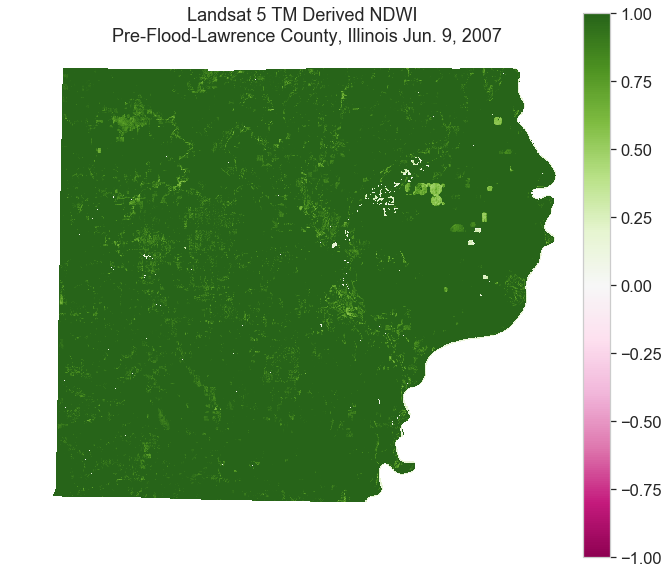

In [13]:
# Calculate NDWI
pre_ndwi_band = es.normalized_diff(b2=green_band_pre_im[0],
                                   b1=nir_band_pre_im[0])

# Plot NDWI for Pre-Flood Event
fig, ax = plt.subplots(figsize=(10, 10))

pre_ndwi = ax.imshow(pre_ndwi_band,
                     cmap='PiYG',
                     vmin=-1,
                     vmax=1)

fig.colorbar(pre_ndwi, fraction=.05)

ax.set(title="Landsat 5 TM Derived NDWI \n Pre-Flood-Lawrence County, Illinois Jun. 9, 2007\n")
ax.set_axis_off()
# Save the image
plt.savefig('images/ndwi_pre_flood.png')
plt.show()

NDWI Derived from Landsat 5 TM pre-flood conditions. Water is depicted in the 0 – 0.25 range, while 0.25 to 1 is some sort of vegetation/ land-use. 

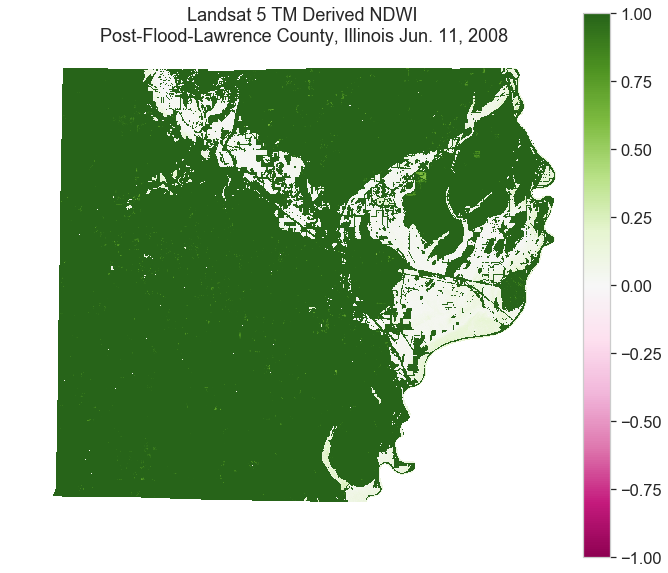

In [14]:
# Calculate NDWI
post_ndwi_band = es.normalized_diff(b2=green_band_post_im[0],
                                    b1=nir_band_post_im[0])

# Plot Post-Flood Event
fig, ax = plt.subplots(figsize=(10, 10))

post_ndwi = ax.imshow(post_ndwi_band,
                      cmap='PiYG',
                      vmin=-1,
                      vmax=1)

fig.colorbar(post_ndwi, fraction=.05)
ax.set(title="Landsat 5 TM Derived NDWI \n Post-Flood-Lawrence County, Illinois Jun. 11, 2008 \n")
ax.set_axis_off()
# Save the image
plt.savefig('images/ndwi_post_flood.png')
plt.show()

NDWI Derived from Landsat 5 TM  post-flood conditions. Water is depicted in the 0 – 0.25 range, while 0.25 to 1 is some sort of vegetation/ land-use. 

### Calculate the difference between pre and post flood NDWI

#### Change Detection Analysis using NDWI Derived Imagery
Even though I was super excited about the results shown above, I began to wonder how do I know that this is actually standing water as a result of flooding. Should I remove the original water bodies (such as rivers and lakes) so that I can only see flood associated water? 

After reading some material related to change detection [1,3], I realized that I needed to remove all original water sources. 

Change detection analysis allows to clearly identify areas that have changes over time by taking the difference between before and after images. In this case, think of this as a way to remove the original water sources from the analysis to identify areas submerged by water. 


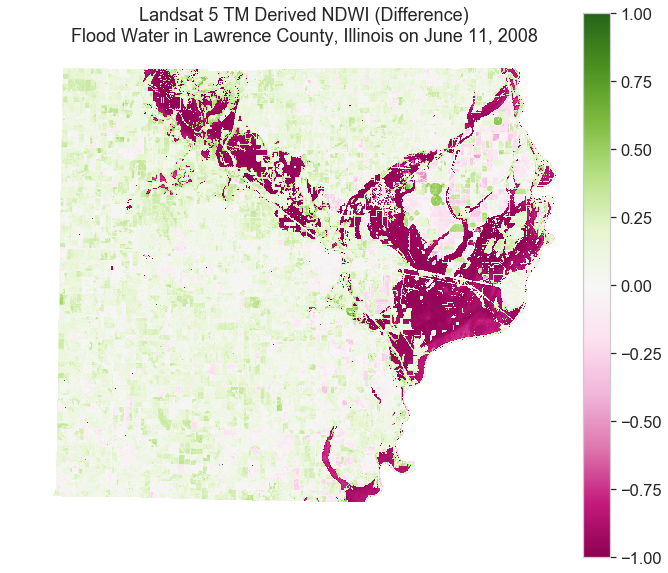

In [15]:
# NDWI flood_extent = post_ndwi_band - pre_ndwi_band
ndwi_flood_extent = es.normalized_diff(b2=post_ndwi_band,
                                       b1=pre_ndwi_band)

# Plot Flood Extent
fig, ax = plt.subplots(figsize=(10, 10))

ndwi_flood = ax.imshow(ndwi_flood_extent,
                       cmap='PiYG',
                       vmin=-1,
                       vmax=1)

fig.colorbar(ndwi_flood, fraction=.05)
ax.set(title="Landsat 5 TM Derived NDWI (Difference)\nFlood Water in Lawrence County, Illinois on June 11, 2008\n")
ax.set_axis_off()
# Save the image
plt.savefig('images/ndwi_difference_flood.png')
plt.show()

## Reclassify NDWI Image

#### 3.	Extract Pixels contacting Flood water: 
In order to distinguish flood related pixels from other variations of lands, I reclassified the NDWI difference image into four classes. 


Many may wonder why I did not reclassify into two classes to clearly depict land and water. My response is that this step took a lot of trial and error due to the histogram outputs and range of pixel values.  I came to the solution to use four classes because it clearly narrowed down flood water related pixels to bin 1 (shown in the image below). I believe that the resulting NDWI difference image still contained some level of noise since the purpose of NDWI is to show water content in an area - hence, picking up the water content in vegetation ( especially since this area is primarily agricultural lands- use).  

C:\Users\tonif_000\Anaconda3\envs\earth-analytics-python\lib\site-packages\numpy\lib\histograms.py:746: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\tonif_000\Anaconda3\envs\earth-analytics-python\lib\site-packages\numpy\lib\histograms.py:747: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


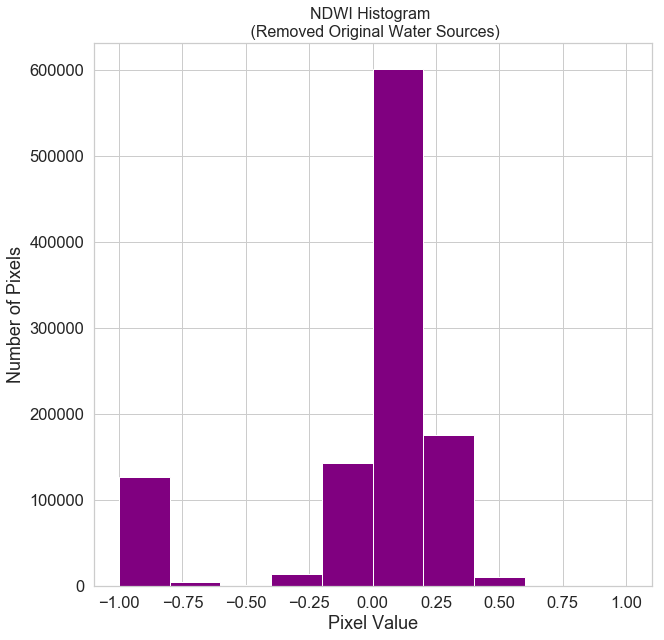

In [16]:
# Plot a histogram of the NDWI difference image
fig, ax = plt.subplots(figsize=(10, 10))

ax.hist(ndwi_flood_extent.ravel(),
        color='purple',
        edgecolor='white')
ax.set_title("NDWI Histogram \n (Removed Original Water Sources)",
             fontsize=16)
ax.set(xlabel="Pixel Value",
       ylabel="Number of Pixels")
# Save the figure
plt.savefig('images/NDWI_histogram.png')
plt.show()

In [17]:
counts, bins, patches = ax.hist(ndwi_flood_extent.ravel(),
                                color='springgreen',
                                bins=4)

In [18]:
class_bins = bins

ndwi_class = np.digitize(ndwi_flood_extent, class_bins)
np.unique(ndwi_class)
#bins

array([1, 2, 3, 4, 5], dtype=int64)

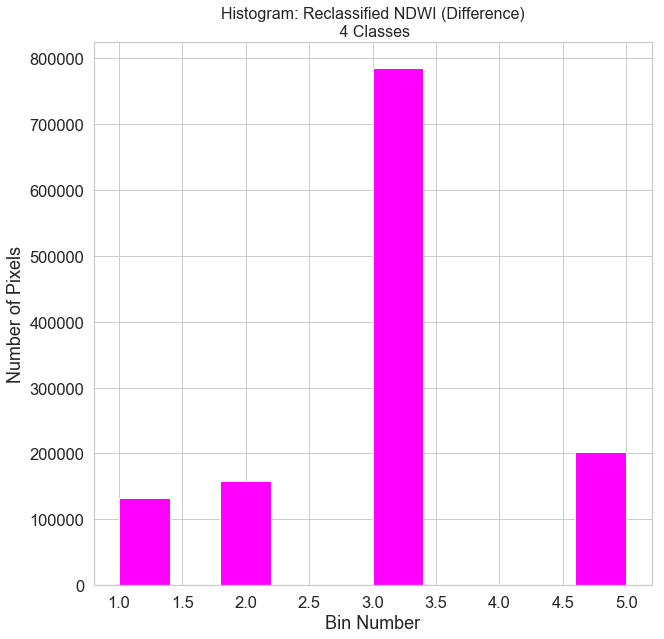

In [19]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.hist(ndwi_class.ravel(),
        color='magenta',
        edgecolor='white')
ax.set_title("Histogram: Reclassified NDWI (Difference)\n 4 Classes",
             fontsize=16)
ax.set(xlabel="Bin Number",
       ylabel="Number of Pixels")
plt.savefig('images/reclassified_histogram.png')
plt.show()

Bin 1 contains pixels that contain flood water values. 

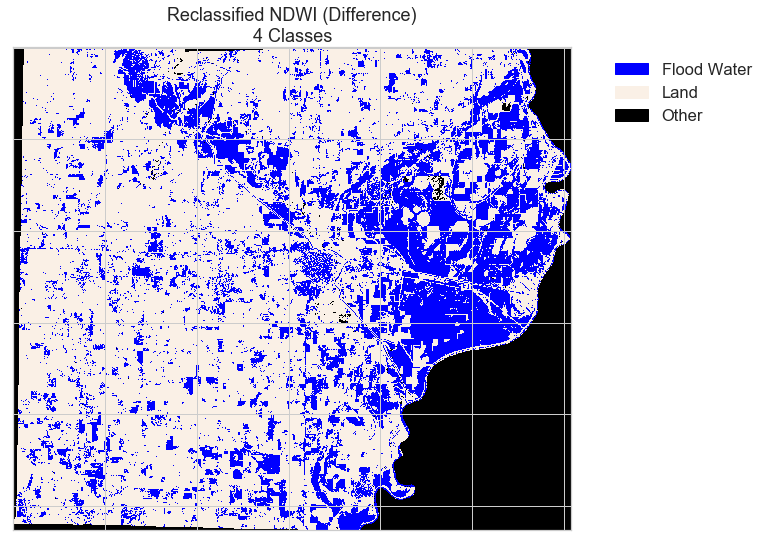

In [20]:
# Plot newly classified and masked raster
fig, ax = plt.subplots(figsize=(10, 10))

colors = ['blue', 'linen', 'black']
class_labels1 = ["Flood Water", "Land", "Other"]
legend_patches1 = [Patch(color=icolor, label=label)
                   for icolor, label in zip(colors, class_labels1)]
cmap = ListedColormap(colors)

ax.imshow(ndwi_class,
          cmap=cmap)

ax.legend(handles=legend_patches1,
          facecolor='white',
          edgecolor='white',
          bbox_to_anchor=(1.35, 1))

ax.set_title("Reclassified NDWI (Difference)\n 4 Classes ")
ax.set_axis_off

# Turn off tick labels
ax.set_yticklabels([])
ax.set_xticklabels([])

plt.savefig('images/reclassified_ndwi.png')
plt.show()

Python enables me to specific with bin number I would like to show and mask all others as “no-data”. Now, the extent of the flood exist in its own image.  

[]

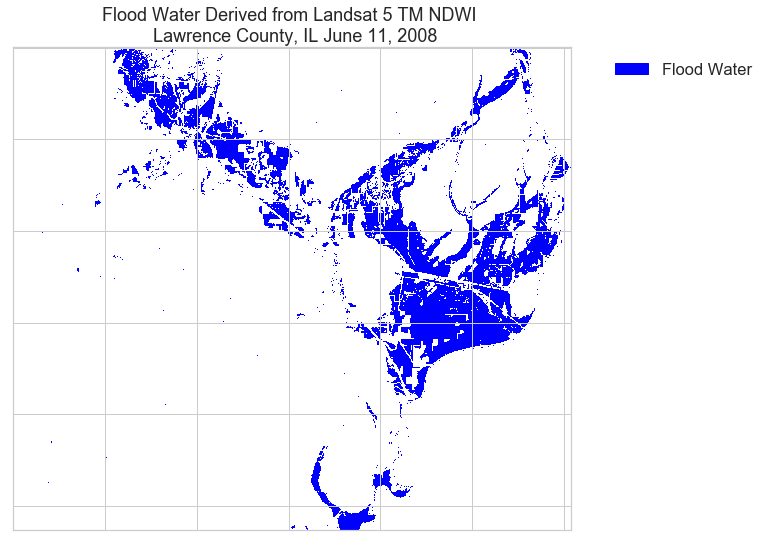

In [21]:
ndwi_class_ma = np.ma.masked_where(ndwi_class != 1,
                                   ndwi_class,
                                   copy=True)
np.unique(ndwi_class_ma)

class_bins = [ndwi_class.min(), 2, np.inf]
colors = ['blue']
cmap = ListedColormap(colors)
norm = BoundaryNorm(class_bins, len(colors))


fig, ax = plt.subplots(figsize=(10, 10))

ax.imshow(ndwi_class_ma,
          cmap=cmap)


# Create a list of labels to use for your legend
height_class_labels = ["Flood Water"]
# A path is an object drawn by matplotlib. In this case a patch is a box drawon your legend
# Below you create a unique path or box with a unique color - one for each ofthe labels above
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(colors, height_class_labels)]
ax.legend(handles=legend_patches,
          facecolor="white",
          edgecolor="white",
          bbox_to_anchor=(1.35, 1))  # Place legend to the RIGHT of the map
ax.set_title(
    "Flood Water Derived from Landsat 5 TM NDWI \n Lawrence County, IL June 11, 2008")
ax.set_axis_off
# Turn off tick labels
ax.set_yticklabels([])
ax.set_xticklabels([])

plt.savefig('images/flood_extent.png')
plt.plot()

All data not in the floodwater class (in this case bin 1) were masked to produce the final product shown on the right

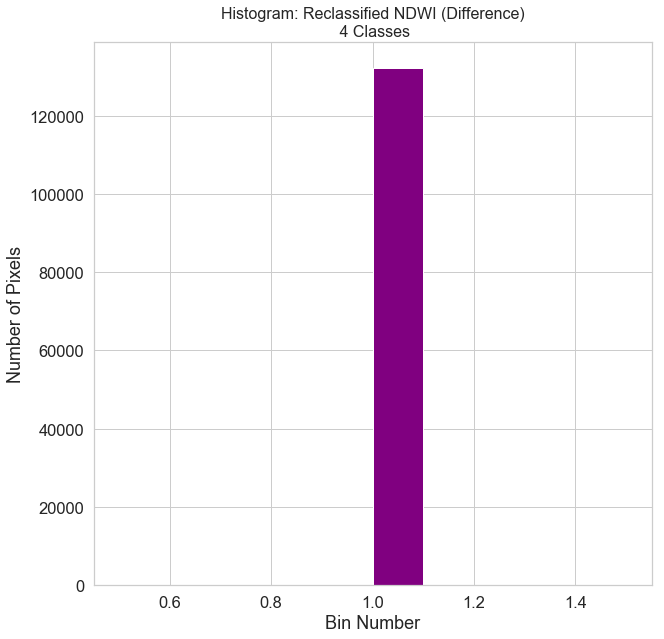

In [22]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.hist(ndwi_class_ma.ravel(),
        color='purple',
        edgecolor='white')
ax.set_title("Histogram: Reclassified NDWI (Difference)\n 4 Classes",
             fontsize=16)
ax.set(xlabel="Bin Number",
       ylabel="Number of Pixels")
plt.savefig('images/reclassified_histogram.png')
plt.show()

NDWI Change derived from Landsat 5 TM. This image shows the flooded area in Lawrence County, Illinoise

#### 4.	Quantify the extent of the flood: 
As a result, I found that the flood extended over approximately 12.4% of the county’s land area! It is important to note that the accuracy of this calculation is as good as the spatial resolution of the satellite imagery the analysis is derived from. 


In [23]:
# Count of pixels times 900 square meters
flood_pixels = (ndwi_class_ma.count())*(30*30)

# Lawrence, IL area
lawrence_area = county_prj.geometry.area

# Calculate the percentage
area_within_extent = (flood_pixels/lawrence_area)*100

Approximate area in the study area is within the flood extent:

In [24]:
area_within_extent

0    12.291506
dtype: float64

## What is the impact of this analysis? 
The impact of this analysis highlights the potential for providing near-real-time flooding information to relief agencies (assuming the data is accessible) and allowing for a fast and timely response for the implementation of evacuation plans and damage assessment. This image product can also be combined with vector data (such as census block groups and roads shapefile) to determine impact and vulnerability to flood events. Furthermore, this analysis can be utilized as a data service resource to government (federal and local) decision makers as well as first responders providing emergency services to the community. 

Implementing python in this analysis allowed for an easy to use application that is open source (if you are indeed familiar with python). I believe that the resulting flood extent raster from my analysis can be utilized with both remote sensing and GIS to complete an assessment the impact of a flood event and allow people to be more informed and make better decisions in disaster management. This information to implement mitigation strategies, such as mapping flood-prone areas, delineating flood-plains, and creating land-use maps.


## Other work done in this area: 

I found the following publications to be very helpful to developing my own methodology ( based on my entry level experience and curiosity of the field). If you find this work to be interesting and want to learn more about a more accurate and in-depth analysis, I highly recommend reading the following publications: 

https://www.mdpi.com/2072-4292/6/5/4173/htm

Kussul, N., Shelestov, A. & Skakun, S. Earth Sci Inform (2008) 1: 105. https://doi.org/10.1007/s12145-008-0014-3


## References: 
[1] Andreoli, Remi & Hervé, Yesou. (2008). CHANGE DETECTION ANALYSIS DEDICATED TO FLOOD MONITORING USING ENVISAT WIDE SWATH MODE DATA Website Accessed on December 11,2018: https://www.researchgate.net/publication/229018921_CHANGE_DETECTION_ANALYSIS_DEDICATED_TO_FLOOD_MONITORING_USING_ENVISAT_WIDE_SWATH_MODE_DATA

[2] Gleason, Karin; “2008 Midwestern U.S. Floods”; July 2008; NOAA’s National Climatic Data Center, Asheville, NC looding of June 2008.
[3] https://www.mdpi.com/2072-4292/6/5/4173/htm

[4] Morlock, S.E., Menke, C.D., Arvin, D.V., and Kim, M.H., 2008, Flood of June 7–9, 2008, in central and southern Indiana: U.S. Geological Survey Open File Report 2008–1322, 15 p., 3 app.

[5] National Weather Service(NWS), December 2009,“Service Assessment: Central United States Flooding of June 2008”: U.S. Department of Commerce, National Weather Service, Silver Springs, Maryland

[6] Xu, Hanqiu. (2006). MODIFICATION OF NORMALIZED WATER INDEX (NDWI) TO ENHANCE OPEN WATER FEATURES IN REMOTELY SENSED IMAGERY. Website Accessed on December 11, 2018 http://www.aari.ru/docs/pub/060804/xuh06.pdf

## Data Sources and Websites: 
- Daily Precipitation: https://www.ncdc.noaa.gov/cdo-web/search 
	Downloaded from:  https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND:USC00114957/detail


- Landsat 5 TM: Earth Explorer: https://earthexplorer.usgs.gov/ 
